# Discovering partial differential equations from data

In this notebook, we will apply the methods of "Discovering governing equations from data by sparse identification of nonlinear dynamical systems" by Brunton et al., 2016 (https://doi.org/10.1073/pnas.1517384113) in order to estimate an unknown partial differential equation from data. This method utilizes spatially and temporally dense observations of some physical system with unknown governing equations. This situation is common in many scientific fields that involve fluid mechanics (e.g., oceanography, glaciology) or some type of diffusion (e.g., heat conduction).

Let's first import some Python packages. We only need to use `numpy`, `scipy`, and `matplotlib` for this exercise.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, LassoCV
import sys
import os

## Loading and visualizing the data

In this exercise, we have observations of a 1D system with state variable $u(x, t)$ over some time vector $t$. Therefore, the partial differential equation (PDE) that controls this system has some form:

$$u_t = \mathcal{F}(u) + \epsilon$$

where $u_t = \frac{\partial u}{\partial t}$ are the time derivatives of $u$, $\mathcal{F}()$ represent some non-linear function of $u$ and its spatial derivatives (e.g., $\frac{\partial u}{\partial x}$, $\frac{\partial^2 u}{\partial x^2}$), and $\epsilon$ is additive noise. __Our task is to learn the form of__ $\boldsymbol{\mathcal{F}}$ __from observations of__ $\mathbf{u}$. Once we have an estimate of $\mathcal{F}$, we will test our equation on a validation dataset.  

<br/>
Let's first load the training dataset. This dataset contains the observations of our system state $u$ and the corresponding time vector $t$.

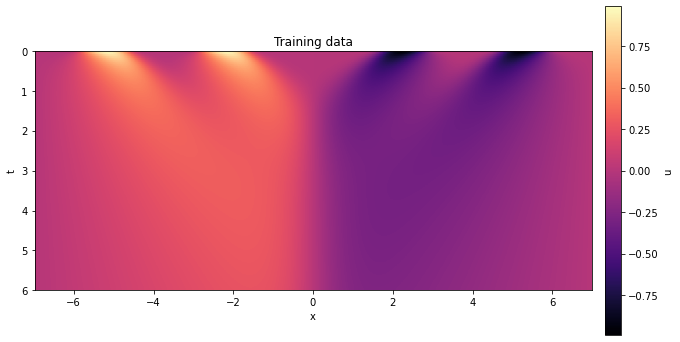

In [85]:
# Load u
u = np.loadtxt('u_train.txt')
# Load t
t = np.loadtxt('t_train.txt')
# Load spatial coordinates x
x = np.loadtxt('coordinates.txt')

# Imshow the simulation data
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(u, extent=[x[0], x[-1], t[-1], t[0]], cmap='magma')
plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label='u')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Training data')
plt.tight_layout()

We can see that $u$ is a 2D array with time along the vertical axis and space along the horizontal axis. At time $t = 0$, the $u$ field has its highest values with two positive peaks on the left side of the domain ($x < 0$) and two negative peaks on the right side of the domain ($x > 0$). As time progresses, these peaks converge towards the center, and $u$ becomes more diffuse (spread out) with lower values. These qualitative observations should already give you a clue about what the form of the PDE should be.

Another way of visualizing the data is to plot profiles of $u$ at different time steps:

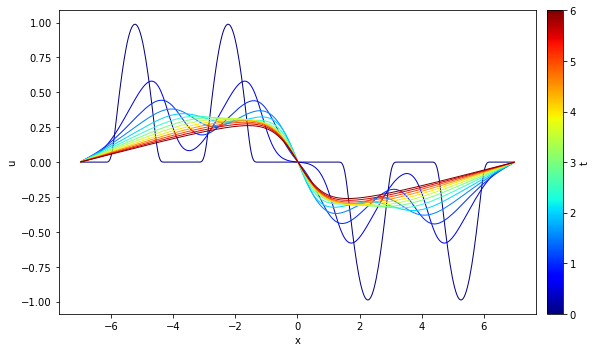

In [86]:
fig, ax = plt.subplots(figsize=(9, 5))

t_colors = plt.get_cmap('jet')(np.linspace(0, 1, t.size))
for i in range(0, t.size, 10):
    ax.plot(x, u[i, :], color=t_colors[i], lw=1)
    
sm = cm.ScalarMappable(colors.Normalize(vmin=t[0], vmax=t[-1]), cmap='jet')
plt.colorbar(sm, ax=ax, pad=0.02, label='t')
ax.set_xlabel('x')
ax.set_ylabel('u')
plt.tight_layout()

## Construct linear system for learning PDEs from data

The SINDy method (spare identification of nonlinear dynamics) represents the PDE as a linear system $\mathbf{Az} = \mathbf{b}$, where:

- $\mathbf{b}$ = $u_t$: vector of time derivatives of $u$
- $\mathbf{A}$ = [$u$, $u_x$, $u_{xx}$, $\ldots$]: matrix of $u$ and non-linear combinations of its spatial derivatives
- $\mathbf{z}$: vector of coefficients multiplying the columns of $\mathbf{A}$

For example, let's say the PDE has the following form: $u_t = 1.25 * u_{xx} + 0.5 * u$. I would create $\mathbf{A}$ and $\mathbf{b}$ using the following:

```python
# Compute time derivative
u_t = np.gradient(u, t, axis=0, edge_order=2)
# Compute spatial derivatives
u_x = np.gradient(u, x, axis=1, edge_order=2)
u_xx = np.gradient(u_x, x, axis=1, edge_order=2)

# Construct A
A = np.column_stack((u_xx.ravel(), u.ravel))

# Construct b
b = u_t.ravel()
```

In that case, the vector $\mathbf{z}$ would have the value $\mathbf{z} = [1.25, 0.5]$.  
<br/>

In the general case, __we don't know what functions to put in the matrix A__. The SINDy method solves this by first constructing $\mathbf{A}$ with _many_ different functions of $u$ and its spatial derivatives (as many as you think could possibly fit the data). Then, a linear regression is performed with an extra penalty that encourages a _sparse_ number (very few) of non-zero coefficients. In other words, we solve the following cost function:

$$C(\mathbf{z}) = \|\mathbf{b} - \mathbf{Az}\|^2 + \alpha \|\mathbf{z}\|_1$$

where $\alpha$ is a scalar parameter that controls the strength of the sparsity penalty: higher $\alpha$ results in fewer non-zero coefficients in $\mathbf{z}$ (but with a potentially worse fit to the data) while a lower $\alpha$ will result in more non-zero coefficients. In this notebook, we will use the `sklearn.linear_model.Lasso` model to solve the above cost function.

<br>
<div class="alert alert-info">
<b>TODO:</b> 

Modify the the `construct_A_b` function below to compute the temporal and spatial derivatives of _u_ in order to form the matrix __A__ and vector __b__. For the matrix __A__, include as many terms as you think are necessary for fitting the data (e.g., ~10 or more).

</div>

In [127]:
def construct_A_b(u, t, N=2000, normalize=True):
    """
    Construct matrix A and vector b for the linear system A * z = b.
    
    Parameters
    ----------
    
    Returns
    -------
    A: ndarray
        Matrix A.
    b: ndarray
        Vector b.
    column_scales: ndarray, optional
        Scale factors for normalizing the columns of A (if normalize=True)
    """
    # Store the shapes
    Nt, Nx = u.shape
    
    # Compute time derivative u_t
    u_t = np.gradient(u, t, axis=0, edge_order=2)
    
    #---------------------------------------------------------
    # TODO: Compute various spatial derivative u_x, u_xx, etc.
    u5 = u**5
    u4 = u**4
    u3 = u**3
    u2 = u**2
    u_x = np.gradient(u, x, axis=1, edge_order=2)
    u_xx = np.gradient(u_x, x, axis=1, edge_order=2)
    u_xxx = np.gradient(u_xx, x, axis=1, edge_order=2)
    u_xxxx = np.gradient(u_xxx, x, axis=1, edge_order=2)
    u_xxxxx = np.gradient(u_xxxx, x, axis=1, edge_order=2)
    #---------------------------------------------------------
    
    # Randomly sample u and its derivatives for constructing A and b
    rng = np.random.default_rng(1337)
    inds = rng.choice(Nt*Nx, size=N, replace=False)
    u, u_t, u_x, u_xx, u2, u3, u5, u4, u_xxx, u_xxxx, u_xxxxx = [arr.ravel()[inds] for arr in (u, u_t, u_x, u_xx, u2, u3, u5, u4, u_xxx, u_xxxx, u_xxxxx)]
    
    #---------------------------------------------------------
    # TODO: Populate the matrix A with as many functions as you think can fit the data
    A = np.column_stack((u5, u4, u3, u2, u, u_x, u_xx, u_xxx, u_xxxx, u_xxxxx))
    #---------------------------------------------------------
    
    # OPTIONAL: compute the maximum absolute value along each column
    # We can use these to normalize each column such that each feature
    # has roughly equal contributions to the prediction A*z
    if normalize:
        column_scales = np.max(np.abs(A), axis=0)
        A = A / column_scales
        return A, u_t, column_scales
    else:
        return A, u_t

## Training

Let's now use the function that we've written to create an __A__ and __b__ for training in order to estimate __z__ and the form of the PDE. One key constraint for this exercise is that __we are only going to use a 1 second span of the observations of u__ for training. 

In [128]:
# Select a one second time span of the data for training
# Let's first look at the last second of simulation data
mask = t > 5
u1 = u[mask, :]
t1 = t[mask]

# Create A and b for this subset
# NOTE: we keep track of the normalizing terms for later
A_train, b_train, column_scales = construct_A_b(u1, t1, normalize=True)

### Cross-validation

In order to use the `sklearn.linear_model.Lasso` model and solver, we need to specify a value for the penalty parameter $\alpha$. But what value is optimal for out data? To address this, we will make use of the `sklearn.linear_model.LassoCV` class to perform a K-fold cross-validation.

<br>
<div class="alert alert-info">
<b>TODO:</b> 

Modify the following block of code to adjust the values of $\alpha$ tested by `LassoCV`. Ideally, the optimal value of $\alpha$ is when the mean square error (MSE) is the lowest (black curve in the following plot). In case there is no obvious minimum value, choose the highest value of $\alpha$ that still produces a relatively low MSE.

</div>

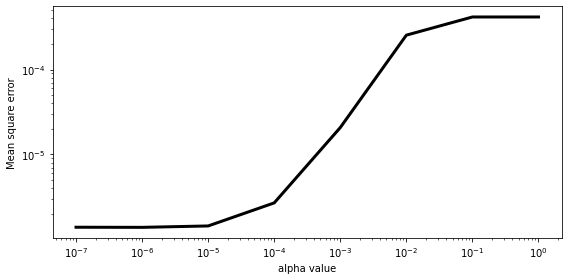

In [129]:
#---------------------------------------------------------
# TODO: modify the instantation of LassoCV to choose an appropriate range of values
# of alphas to test and an appropriate number of cross-validation folds
cv = LassoCV(alphas=[10**n for n in range (-7,1)],
            fit_intercept=False,
            cv=2,
            max_iter=10000,
            random_state=50)
cv.fit(A_train, b_train);
#---------------------------------------------------------

# Now plot the cross-validation performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(cv.alphas_, cv.mse_path_, lw=0.75, alpha=0.75)
ax.loglog(cv.alphas_, cv.mse_path_.mean(axis=-1), 'k', lw=3)
ax.set_xlabel('alpha value')
ax.set_ylabel('Mean square error')
plt.tight_layout()

### Lasso fit with the optimum value of $\alpha$

After selecting an optimum value of $\alpha$, we can now call the `Lasso` model and print out the coefficients in __z__. Ideally, low values of __z__ indicate that those functions in __A__ are not good at predicting signals in the data.

The estimated coefficients are:
0 7.142204838057798
1 -0.0
2 -0.0
3 -0.0009279012501933621
4 -0.14430148868562648
5 0.0007840904157468459
6 -0.03691201310412249
7 0.0
8 -0.0010478772703394023
9 -0.0


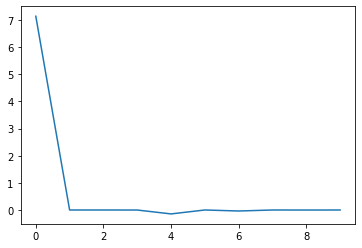

In [130]:
#---------------------------------------------------------
# TODO: Perform lasso fit with optimum alpha value from your
# cross-validation curve
lasso = Lasso(alpha=1e-5,
              max_iter=10000)
lasso.fit(A_train, b_train)
#---------------------------------------------------------

# Make a plot of the coefficients
# NOTE: we need to divide by column_scales in order
# to account for the normalization of A
plt.plot(lasso.coef_ / column_scales)

# When printing out the coefficients of the system, again make sure to account for
# the normalization of A
print('The estimated coefficients are:')
for i in range(lasso.coef_.size):
    print(i, lasso.coef_[i] / column_scales[i])

## Validation

Now that we have an estimated PDE (using the non-zero coefficients in __z__), let's apply the PDE to a validation dataset. This dataset is the last two seconds of the simulation used for training. Let's have a look at the data first:

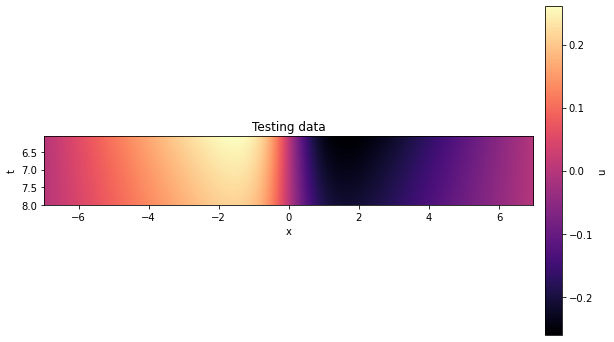

In [126]:
# Load u
u_test = np.loadtxt('u_test.txt')
# Load t
t_test = np.loadtxt('t_test.txt')

# Imshow the simulation data
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(u_test, extent=[x[0], x[-1], t_test[-1], t_test[0]], cmap='magma')
plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label='u')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Testing data')
plt.tight_layout()

For validating your model, we will compute the time derivative of the test data, which will then be compared to the predicted time derivative using what you think is the PDE that best fits the training data.

<br>
<div class="alert alert-info">
<b>TODO:</b> 

Modify the following block of code to apply your estimated model to the test data in order to get a predicted $u_t$. Then plot images of the true and predicted $u_t$ along with the prediction errors. How well did your model perform on the test data?

</div>

Model perform well at high and low x and not so well when x is close to zero.

Text(0.5, 1.0, 'Difference')

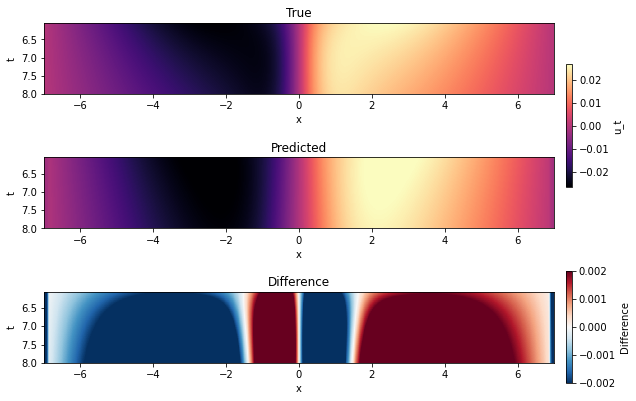

In [136]:
# The time derivatives of the test data are the target values
u_t_test = np.gradient(u_test, t_test, axis=0, edge_order=2)

#---------------------------------------------------------
# TODO: Compute the necessary components of your estimated physical equation
# NOTE: you must compute spatial gradients on u_test
u2 = u_test**2
u3 = u_test**3
u4 = u_test**4
u5 = u_test**5
u_x = np.gradient(u_test, x, axis=1, edge_order=2)
u_xx = np.gradient(u_x, x, axis=1, edge_order=2)
u_xxx = np.gradient(u_xx, x, axis=1, edge_order=2)
u_xxxx = np.gradient(u_xxx, x, axis=1, edge_order=2)
u_xxxxx = np.gradient(u_xxxx, x, axis=1, edge_order=2)
u_t_pred = lasso.coef_[0] / column_scales[0] * u5 + lasso.coef_[1] / column_scales[1] * u4 + lasso.coef_[2] / column_scales[2] * u3 + lasso.coef_[3] / column_scales[3] * u2 + lasso.coef_[4] / column_scales[4] * u_test + lasso.coef_[5] / column_scales[5] * u_x + lasso.coef_[6] / column_scales[6] * u_xx + lasso.coef_[7] / column_scales[7] * u_xxx + lasso.coef_[8] / column_scales[8] * u_xxxx + lasso.coef_[9] / column_scales[9] * u_xxxxx  # manually evaluate your estimated model, e.g. u_t_pred = 0.1 * u_xx + 2 * u
#---------------------------------------------------------

# Make some plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(11, 7))
extent = [x[0], x[-1], t_test[-1], t_test[0]]

im1 = ax1.imshow(u_t_test, extent=extent, cmap='magma')
im2 = ax2.imshow(u_t_pred, extent=extent, clim=(im1.get_clim()), cmap='magma')

im3 = ax3.imshow(u_t_pred - u_t_test, extent=extent, cmap='RdBu_r', clim=(-0.002, 0.002))

cbar1 = plt.colorbar(im1, ax=[ax1, ax2], pad=0.02, shrink=0.5, label='u_t')
cbar2 = plt.colorbar(im3, ax=ax3, pad=0.02, label='Difference')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('x')
    ax.set_ylabel('t')
ax1.set_title('True')
ax2.set_title('Predicted')
ax3.set_title('Difference')

<br>
<div class="alert alert-info">
<b>TODO:</b> 

- Repeat the above analysis with a __different 1 second time span__ of training data. Specifically, use a time span with different dynamical characteristics than the one you originally used for training. For example, if you originally used $t < 1$, try using $t > 5$.
- Does your estimated model change at all? Do your cross-validation curve and optimal $\alpha$ value change? Explain any changes and provide some physical interpretations.

</div>

In [144]:
# Select a one second time span of the data for training
# Let's first look at the last second of simulation data
mask = t < 1
u1 = u[mask, :]
t1 = t[mask]

# Create A and b for this subset
# NOTE: we keep track of the normalizing terms for later
A_train, b_train, column_scales = construct_A_b(u1, t1, normalize=True)



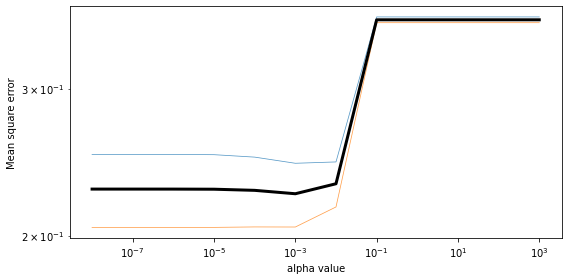

In [145]:
#---------------------------------------------------------
# TODO: modify the instantation of LassoCV to choose an appropriate range of values
# of alphas to test and an appropriate number of cross-validation folds
cv = LassoCV(alphas=[10**n for n in range (-8,4)],
            fit_intercept=False,
            cv=2,
            max_iter=10000,
            random_state=50)
cv.fit(A_train, b_train);
#---------------------------------------------------------

# Now plot the cross-validation performance
fig, ax = plt.subplots(figsize=(8, 4))
ax.loglog(cv.alphas_, cv.mse_path_, lw=0.75, alpha=0.75)
ax.loglog(cv.alphas_, cv.mse_path_.mean(axis=-1), 'k', lw=3)
ax.set_xlabel('alpha value')
ax.set_ylabel('Mean square error')
plt.tight_layout()

The estimated coefficients are:
0 -0.0
1 -0.0
2 -0.44082706190892473
3 0.0025685620000259926
4 -0.0
5 -0.006631778217446695
6 0.2238741739079998
7 -0.0
8 6.125982844870295e-05
9 0.0


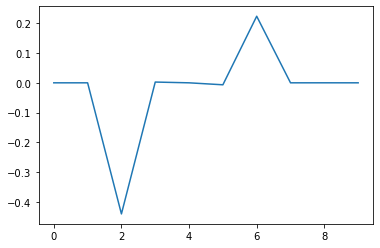

In [147]:
#---------------------------------------------------------
# TODO: Perform lasso fit with optimum alpha value from your
# cross-validation curve
lasso = Lasso(alpha=1e-3,
              max_iter=10000)
lasso.fit(A_train, b_train)
#---------------------------------------------------------

# Make a plot of the coefficients
# NOTE: we need to divide by column_scales in order
# to account for the normalization of A
plt.plot(lasso.coef_ / column_scales)

# When printing out the coefficients of the system, again make sure to account for
# the normalization of A
print('The estimated coefficients are:')
for i in range(lasso.coef_.size):
    print(i, lasso.coef_[i] / column_scales[i])

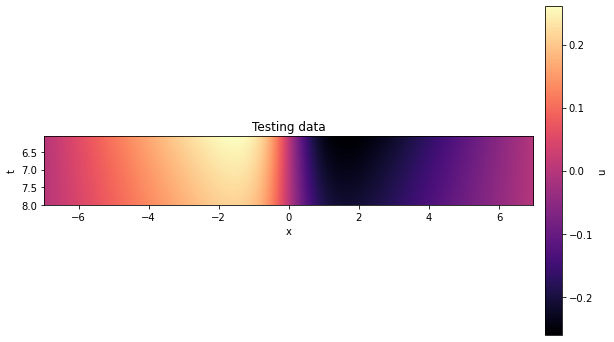

In [148]:
# Load u
u_test = np.loadtxt('u_test.txt')
# Load t
t_test = np.loadtxt('t_test.txt')

# Imshow the simulation data
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(u_test, extent=[x[0], x[-1], t_test[-1], t_test[0]], cmap='magma')
plt.colorbar(im, ax=ax, pad=0.02, shrink=0.8, label='u')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Testing data')
plt.tight_layout()

Text(0.5, 1.0, 'Difference')

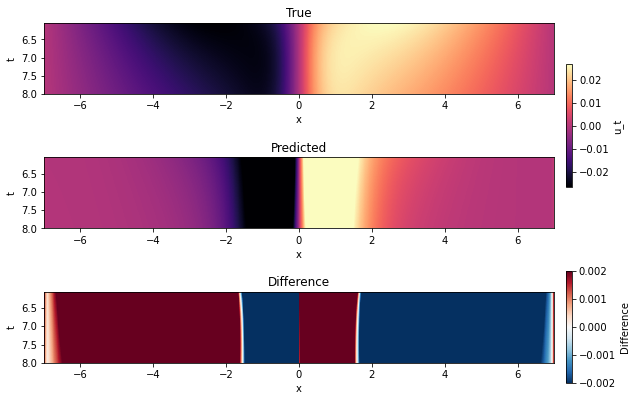

In [149]:
# The time derivatives of the test data are the target values
u_t_test = np.gradient(u_test, t_test, axis=0, edge_order=2)

#---------------------------------------------------------
# TODO: Compute the necessary components of your estimated physical equation
# NOTE: you must compute spatial gradients on u_test
u2 = u_test**2
u3 = u_test**3
u4 = u_test**4
u5 = u_test**5
u_x = np.gradient(u_test, x, axis=1, edge_order=2)
u_xx = np.gradient(u_x, x, axis=1, edge_order=2)
u_xxx = np.gradient(u_xx, x, axis=1, edge_order=2)
u_xxxx = np.gradient(u_xxx, x, axis=1, edge_order=2)
u_xxxxx = np.gradient(u_xxxx, x, axis=1, edge_order=2)
u_t_pred = lasso.coef_[0] / column_scales[0] * u5 + lasso.coef_[1] / column_scales[1] * u4 + lasso.coef_[2] / column_scales[2] * u3 + lasso.coef_[3] / column_scales[3] * u2 + lasso.coef_[4] / column_scales[4] * u_test + lasso.coef_[5] / column_scales[5] * u_x + lasso.coef_[6] / column_scales[6] * u_xx + lasso.coef_[7] / column_scales[7] * u_xxx + lasso.coef_[8] / column_scales[8] * u_xxxx + lasso.coef_[9] / column_scales[9] * u_xxxxx  # manually evaluate your estimated model, e.g. u_t_pred = 0.1 * u_xx + 2 * u
#---------------------------------------------------------

# Make some plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(11, 7))
extent = [x[0], x[-1], t_test[-1], t_test[0]]

im1 = ax1.imshow(u_t_test, extent=extent, cmap='magma')
im2 = ax2.imshow(u_t_pred, extent=extent, clim=(im1.get_clim()), cmap='magma')

im3 = ax3.imshow(u_t_pred - u_t_test, extent=extent, cmap='RdBu_r', clim=(-0.002, 0.002))

cbar1 = plt.colorbar(im1, ax=[ax1, ax2], pad=0.02, shrink=0.5, label='u_t')
cbar2 = plt.colorbar(im3, ax=ax3, pad=0.02, label='Difference')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('x')
    ax.set_ylabel('t')
ax1.set_title('True')
ax2.set_title('Predicted')
ax3.set_title('Difference')

Estimated model not change but cross-validation curve and $\alpha$ has changed.

Alpha become bigger when t<1 than t>5

Maybe because t>5 is closer to the last 2 second. then in order to solute overfit. we need a smaller $\alpha$

And by observing the data. t>5 is more fit to model so we need a smaller $\alpha$
